# Port ANCCR function to Python

Utilizing `calculateANCCR` function in `ANCCR.functions.calculateANCCR.m`.

In [1]:
from typing import Dict, List

import numpy as np

In [2]:
meanITI = 12
numrewards = 500

# anccr model parameters
samplingperiod = 0.2
alpha_anccr = {}
alpha_anccr["exponent"] = 0.1
alpha_anccr["init"] = 0.25
alpha_anccr["min"] = 0.02
alpha_r = 0.2
w = 0.5          
k = 1
minimumrate = 10 ** -3
maximumjitter = 0.1
beta = np.array([[1]])  # Check what beta does in calculate_anccr
threshold = 0.6
T = meanITI*10  # have very large T

nIter = 100
rwrsp = np.zeros((numrewards,nIter))

In [3]:
def simulate_background_reward(numrewards, rewITI, rewlabel, rewmag, truncation):
    """
    Output an eventlog with exclusively background
    rewards. Inputs may be scalar or arrays depending on the number of unique
    background rewards specified.
    """
    labels = np.array([rewlabel] * numrewards)
    rewards = np.array([rewmag] * numrewards)
    ts = np.random.exponential(rewITI, numrewards).cumsum().round(4)
    eventlog = np.array([labels, ts, rewards]).T
    
    return eventlog

In [4]:
def test_simulate_background_reward():
    expected = np.array([
        [1] * 10,
        [
            2.4589,
            3.6462,
            28.4103,
            29.4976,
            34.9972,
            62.9270,
            78.2671,
            85.5094,
            86.0305,
            86.4594,
        ],
        [1] * 10]
    ).T
    actual = simulate_background_reward(10, 12, 1, 1, 0)
    
    assert expected.shape == actual.shape, f"{actual.shape} is not {expected.shape}"
    
test_simulate_background_reward()

In [5]:
eventlog = simulate_background_reward(5, 12, 1, 1, 0)
eventlog

array([[ 1.    ,  4.5778,  1.    ],
       [ 1.    ,  9.1556,  1.    ],
       [ 1.    , 35.6823,  1.    ],
       [ 1.    , 38.9119,  1.    ],
       [ 1.    , 60.7718,  1.    ]])

In [6]:
eventlog[:,1] += 1
eventlog

array([[ 1.    ,  5.5778,  1.    ],
       [ 1.    , 10.1556,  1.    ],
       [ 1.    , 36.6823,  1.    ],
       [ 1.    , 39.9119,  1.    ],
       [ 1.    , 61.7718,  1.    ]])

# Bing Chat attempt at porting calculate_anccr

In [9]:
eventlog = simulate_background_reward(numrewards, meanITI, 1, 1, 0)
eventlog[:,1] += 1

In [10]:
eventlog[:10,]

array([[  1.    ,  14.7536,   1.    ],
       [  1.    ,  32.3297,   1.    ],
       [  1.    ,  47.9995,   1.    ],
       [  1.    ,  61.1165,   1.    ],
       [  1.    ,  68.3891,   1.    ],
       [  1.    ,  96.5202,   1.    ],
       [  1.    , 105.4705,   1.    ],
       [  1.    , 107.5218,   1.    ],
       [  1.    , 112.3021,   1.    ],
       [  1.    , 126.2021,   1.    ]])

## Old but altered. And working!!

In [102]:
def calculate_anccr_beta2(
    eventlog: np.array,
    T: int,
    alpha: dict,
    k: int,
    samplinginterval: float,
    w: float,
    threshold: float,
    minimumrate: float,
    beta: np.array,
    alpha_r: float,
    maximumjitter: float,
    optolog=None,
    omidx=[np.nan, np.nan],
    exact_mean_or_not=0,
    nevent_for_edge=0
) -> np.array:
    
    if alpha_r > 1:
        alpha_r = 1

    if optolog is None or np.isnan(optolog).any():
        optolog = np.zeros((eventlog.shape[0], 2))

    if omidx is None or np.isnan(omidx).any():
        # First entry is omission index, second entry is corresponding reward index
        # omidx = [np.nan, np.nan]
        omidx = np.array([[np.nan], [np.nan]])

    # if exact_mean_or_not=1, calculate exact mean for Mij instead of using alpha
    exact_mean_or_not = exact_mean_or_not

    # if nevent_for_edge>0, use averaged NC for last nevent to calculate edge
    nevent_for_edge = nevent_for_edge

    # omtrue: whether the omission state will be used or not in the calculation of ANCCR
    omtrue = np.zeros((omidx.shape[1],), dtype=bool)
    
    uniquetime = np.unique(eventlog[:, 1])

    # if more than one event happens at the same time, assume random perceptual delay between them
    for jt in range(len(uniquetime)):
        if sum(eventlog[:, 1] == uniquetime[jt]) == 1:
            continue
        idx = np.where(eventlog[:, 1] == uniquetime[jt])[0]
        eventlog[idx[1:], 1] += np.random.randn(len(idx) - 1) * maximumjitter

    eventlog = eventlog[eventlog[:, 1].argsort()]
    
    ntime = eventlog.shape[0]
    
    nstimuli = len(np.unique(eventlog[:, 0]))
    
    samplingtime = np.arange(0, eventlog[-1, 1], samplinginterval)
    
    # if T is a vector, use T(jt) for the calculation at time jt. otherwise, use fixed T
    if isinstance(T, (int, float)):
        T = np.full((eventlog.shape[0],), T)
    
    gamma = np.exp(-1 / T)
    
    # Initialize model values
    Eij = np.zeros((nstimuli, ntime))
    Ei = np.zeros((nstimuli, ntime+1))
    Mi = np.zeros((nstimuli, ntime+1))
    Delta = np.zeros((nstimuli, ntime))
    
    Mij = np.zeros((nstimuli, nstimuli, ntime))
    PRC = np.zeros((nstimuli, nstimuli, ntime))
    SRC = np.zeros((nstimuli, nstimuli, ntime))
    NC = np.zeros((nstimuli, nstimuli, ntime))
    ANCCR = np.zeros((nstimuli, nstimuli, ntime))
    Rs = np.zeros((nstimuli, nstimuli, ntime))
    
    R = np.zeros((nstimuli, nstimuli))
    
    numevents = np.zeros((nstimuli,))
    
    DA = np.zeros((ntime,))
    
    beta = beta[np.unique(eventlog[:, 0]).astype(int)[0] - 1]
    
    Imct = beta > threshold
    
    nextt = 0
    numsampling = 0
    
    for jt in range(ntime):
        skip = False
        je = int(eventlog[jt, 0]) - 1

        if je in omidx[0]:
            if not omtrue[omidx[0] == je]:
                Delta[:, jt] = Delta[:, jt - 1]
                Eij[:, jt] = Eij[:, jt - 1]
                Mij[:, :, jt] = Mij[:, :, jt - 1]
                PRC[:, :, jt] = PRC[:, :, jt - 1]
                SRC[:, :, jt] = SRC[:, :, jt - 1]
                NC[:, :, jt] = NC[:, :, jt - 1]
                skip = True
                
        if not skip:
            numevents[je] += 1
            if exact_mean_or_not == 0:
                if not isinstance(alpha, dict):
                    alphat = alpha
                else:
                    # if alpha is structure, alpha exponentially decreases from alpha.init to alpha.min w/ alpha.exponent decrease constant
                    alphat = np.exp(-alpha['exponent'] * (jt + 1)) * (alpha['init'] - alpha['min']) + alpha['min']
            else:
                alphat = 1 / numevents[je]

            if jt > 0:
                # update delta w/prev value
                Delta[:, jt] = Delta[:, jt - 1] * gamma[jt] ** (eventlog[jt, 1] - eventlog[jt - 1, 1])
                # update instantaneous elig. trace w/prev value
                Eij[:, jt] = Eij[:, jt - 1] * gamma[jt] ** (eventlog[jt, 1] - eventlog[jt - 1, 1])
                # update average elig. trace w/prev value
                Mij[:, :, jt] = Mij[:, :, jt - 1]
                # update anccr w/prev value
                ANCCR[~np.isin(np.arange(nstimuli), je), :, jt] = ANCCR[~np.isin(np.arange(nstimuli), je), :, jt - 1]

            # Indicator for whether event has recently happened
            # Delta resets to one at every instance of event w/o cumulative sum
            Delta[je, jt] = 1
            # Increment inst. elig. trace by 1 for event that occurred
            Eij[je, jt] += 1
            # Update avg. elig. trace
            Mij[:, je, jt] += alphat * (Eij[:, jt] - Mij[:, je, jt]) * Imct[je]

            # Subtract baseline elig. from avg. elig. to find successor rep.
            PRC[:, :, jt] = Mij[:, :, jt] - np.tile(Mi[:, jt], (nstimuli, 1)).T
            # Calculate predecessor rep from successor rep.
            SRC[:, :, jt] = PRC[:, :, jt] * np.tile(Mi[:, jt], (nstimuli, 1)) / np.tile(Mi[:, jt], (nstimuli, 1)).T
            # Zero out values that may approach -Inf
            belowminrate = Mi[:, jt] / T[jt] < minimumrate
            SRC[belowminrate, :, jt] = 0
            
            # something to make sure only calculating contingency and R after experiencing first outcome
            PRC[numevents == 0, :, jt] = 0
            PRC[:, numevents == 0, jt] = 0
            SRC[numevents == 0, :, jt] = 0
            SRC[:, numevents == 0, jt] = 0
            R[:, numevents == 0] = 0
            R[numevents == 0, :] = 0

            # Calculate net contingency, weighted sum of SRC/PRC
            NC[:, :, jt] = w * SRC[:, :, jt] + (1 - w) * PRC[:, :, jt]

            # Indicator for whether an event is associated with another event
            Iedge = np.mean(NC[:, je, max([0, jt - nevent_for_edge]):jt+1], axis=1) > threshold
            Iedge[je] = False

            # once the cause of reward state is revealed, omission state of that reward state can be used for calculation of ANCCR. Before that, omission state is ignored
            if je in omidx[1] and np.sum(Iedge) > 0:
                omtrue[omidx[1] == je] |= True

            # calculate ANCCR for every event
            # Rjj is externally driven; the magnitude of stimulus an animal just experienced
            R[je, je] = eventlog[jt, 2]

            for ke in range(nstimuli):
                # Update edge indicator
                Iedge_ke = np.mean(NC[:, ke, max([0, jt - nevent_for_edge]):jt+1], axis=1) > threshold
                Iedge_ke[ke] = False
                # update ANCCR
                ANCCR[ke, :, jt] = NC[ke, :, jt] * R[ke, :] - np.sum(ANCCR[:, :, jt] * Delta[:, jt].reshape(-1,1) * np.tile(Iedge_ke.reshape(-1,1), (1,nstimuli)), axis=0)

            if not (optolog[jt, 0] == 1): # If target is not inhibited, normal DA
                DA[jt] = np.sum(ANCCR[je,:,jt]*Imct) + beta[je]
            else: # If target is inhibited, replace DA
                DA[jt] = optolog[jt,1]

            if je in omidx[0]:
                je_om = np.where(je == omidx[0])[0]
                # if the current state is omission of j, R(omission,j) = R(j,j)
                R[je, omidx[je_om, 1]] = R[omidx[je_om, 1], omidx[je_om, 1]]
                # omission state is an MCT
                Imct[je] = True

            # This must come after opto s.t. Imct is not formed before opto applied
            Imct[je] |= DA[jt] + beta[je] > threshold

            # Update estimated reward value
            Rs[:, :, jt] = R
            if DA[jt] >= 0:
                # For positive DA response, use standard update rule
                R[:, je] += alpha_r * (eventlog[jt, 2] - R[:, je])
            else:
                # For negative DA response, use overprediction update rule
                if np.any(Iedge):
                    R[Iedge, je] -= alpha_r * R[Iedge, je] * ((Delta[Iedge, jt] / numevents[Iedge]) / np.sum((Delta[Iedge, jt] / numevents[Iedge])))
                else:
                    R[:, je] = R[:, je]
        
        # Update sample eligibility trace (Mi-)
        if jt < ntime:
            # Time to sample baseline b/t events
            if jt + 1 < len(eventlog):
                subsamplingtime = samplingtime[(samplingtime >= eventlog[jt, 1]) & (samplingtime < eventlog[jt+1, 1])]
            else:
                subsamplingtime = samplingtime[(samplingtime >= eventlog[jt, 1])]

            Ei[:, jt+1] = Ei[:, jt] * gamma[jt] ** samplinginterval
            if subsamplingtime.size > 0:
                for jjt in range(nextt, jt + 1):
                    if eventlog[jjt, 0] in omidx[0]:
                        if not omtrue[omidx[0, 0] == eventlog[jjt, 0]]:
                            continue
                    Ei[int(eventlog[jjt, 0]) - 1, jt+1] += gamma[jt] ** (subsamplingtime[0] - eventlog[jjt, 1])
                nextt = jt + 1

            # update alpha of sample eligibility trace
            if exact_mean_or_not == 0:
                if not isinstance(alpha, dict):
                    alphat = alpha
                else:
                    alphat = np.exp(-alpha['exponent'] * (jt + 1)) * (alpha['init'] - alpha['min']) + alpha['min']
            else:
                alphat = 1 / (numsampling + 1)

            # Update avg. sample eligibility trace
            Mi[:, jt+1] = Mi[:, jt] + k * alphat * (Ei[:, jt+1] - Mi[:, jt])
            for iit in range(1, len(subsamplingtime)):
                iit += 1
                if exact_mean_or_not == 0:
                    if not isinstance(alpha, dict):
                        alphat = alpha
                    else:
                        alphat = np.exp(-alpha['exponent'] * (jt + 1)) * (alpha['init'] - alpha['min']) + alpha['min']
                else:
                    alphat = 1 / (numsampling + iit)

                Ei[:, jt+1] *= gamma[jt] ** samplinginterval
                Mi[:, jt+1] += k * alphat * (Ei[:, jt+1] - Mi[:, jt+1])
            numsampling += len(subsamplingtime)
            
    return DA,ANCCR,PRC,SRC,NC,Rs,Delta,Mij,Mi
    

## Attempt to simplify

In [18]:
import numpy as np

def initialize_variables(eventlog, nstimuli, ntime, T):
    """Initialize model variables."""
    Eij = np.zeros((nstimuli, ntime))
    Ei = np.zeros((nstimuli, ntime+1))
    Mi = np.zeros((nstimuli, ntime+1))
    Delta = np.zeros((nstimuli, ntime))
    Mij = np.zeros((nstimuli, nstimuli, ntime))
    PRC = np.zeros((nstimuli, nstimuli, ntime))
    SRC = np.zeros((nstimuli, nstimuli, ntime))
    NC = np.zeros((nstimuli, nstimuli, ntime))
    ANCCR = np.zeros((nstimuli, nstimuli, ntime))
    Rs = np.zeros((nstimuli, nstimuli, ntime))
    R = np.zeros((nstimuli, nstimuli))
    numevents = np.zeros((nstimuli,))
    DA = np.zeros((ntime,))
    gamma = np.exp(-1 / T)
    return Eij, Ei, Mi, Delta, Mij, PRC, SRC, NC, ANCCR, Rs, R, numevents, DA, gamma

def handle_simultaneous_events(eventlog, maximumjitter):
    """Handle simultaneous events by adding random perceptual delay."""
    uniquetime = np.unique(eventlog[:, 1])
    for jt in range(len(uniquetime)):
        if sum(eventlog[:, 1] == uniquetime[jt]) == 1:
            continue
        idx = np.where(eventlog[:, 1] == uniquetime[jt])[0]
        eventlog[idx[1:], 1] += np.random.randn(len(idx) - 1) * maximumjitter
    eventlog = eventlog[eventlog[:, 1].argsort()]
    return eventlog


def handle_omission_state(
    Delta: np.array,
    Eij: np.array,
    Mij: np.array,
    PRC: np.array,
    SRC: np.array,
    NC: np.array,
    jt: int
):
    """Handle omission state."""
    Delta[:, jt] = Delta[:, jt - 1]
    Eij[:, jt] = Eij[:, jt - 1]
    Mij[:, :, jt] = Mij[:, :, jt - 1]
    PRC[:, :, jt] = PRC[:, :, jt - 1]
    SRC[:, :, jt] = SRC[:, :, jt - 1]
    NC[:, :, jt] = NC[:, :, jt - 1]

    return Delta, Eij, Mij, PRC, SRC, NC


def get_alphat(alpha, jt, numevents, je, exact_mean_or_not):
    """Get the alphat value."""
    if exact_mean_or_not == 0:
        if not isinstance(alpha, dict):
            alphat = alpha
        else:
            # If alpha is a dictionary, alpha exponentially decreases from alpha['init'] to alpha['min'] with alpha['exponent'] decrease constant
            alphat = np.exp(-alpha['exponent'] * (jt + 1)) * (alpha['init'] - alpha['min']) + alpha['min']
    else:
        alphat = 1 / numevents[je]
    
    return alphat


def update_with_previous_value(
    Delta: np.array,
    Eij: np.array,
    Mij: np.array,
    ANCCR: np.array,
    je: int,
    jt: int,
    gamma: np.array,
    eventlog: np.array,
    nstimuli: int
):
    """Update with previous value if jt > 0."""
    if jt > 0:
        # update delta with previous value
        Delta[:, jt] = Delta[:, jt - 1] * gamma[jt] ** (eventlog[jt, 1] - eventlog[jt - 1, 1])
        # update instantaneous eligibility trace with prev value
        Eij[:, jt] = Eij[:, jt - 1] * gamma[jt] ** (eventlog[jt, 1] - eventlog[jt - 1, 1])
        # update average eligibility trace with previous value
        Mij[:, :, jt] = Mij[:, :, jt - 1]
        # update anccr with previous value
        ANCCR[~np.isin(np.arange(nstimuli), je), :, jt] = ANCCR[~np.isin(np.arange(nstimuli), je), :, jt - 1]

    return Delta, Eij, Mij, ANCCR


def update_eligibility_traces(Delta, Eij, Mij, je, jt, alphat, Imct):
    """Update instantaneous and average eligibility traces."""
    # Indicator for whether event has recently happened
    # Delta resets to one at every instance of event w/o cumulative sum
    Delta[je, jt] = 1
    # Increment inst. elig. trace by 1 for event that occurred
    Eij[je, jt] += 1
    # Update avg. elig. trace
    Mij[:, je, jt] += alphat * (Eij[:, jt] - Mij[:, je, jt]) * Imct[je]

    return Delta, Eij, Mij

def update_representations(PRC, Mij, Mi, SRC, jt, nstimuli, T, minimumrate):
    """Update representations based on eligibility traces."""
    # Subtract baseline elig. from avg. elig. to find successor rep.
    PRC[:, :, jt] = Mij[:, :, jt] - np.tile(Mi[:, jt], (nstimuli, 1)).T
    # Calculate predecessor rep from successor rep.
    SRC[:, :, jt] = PRC[:, :, jt] * np.tile(Mi[:, jt], (nstimuli, 1)) / np.tile(Mi[:, jt], (nstimuli, 1)).T
    # Zero out values that may approach -Inf
    belowminrate = Mi[:, jt] / T[jt] < minimumrate
    SRC[belowminrate, :, jt] = 0

    return PRC, SRC

def ensure_first_outcome(PRC, SRC, R, numevents, jt):
    """Make sure only calculating contingency and R after experiencing first outcome."""
    # something to make sure only calculating contingency and R after experiencing first outcome
    PRC[numevents == 0, :, jt] = 0
    PRC[:, numevents == 0, jt] = 0
    SRC[numevents == 0, :, jt] = 0
    SRC[:, numevents == 0, jt] = 0
    R[:, numevents == 0] = 0
    R[numevents == 0, :] = 0

    return PRC, SRC, R

def update_contingency(NC, SRC, PRC, w, R, je, jt, nevent_for_edge, threshold, omtrue, omidx):
    """Update Net Contingency (NC) matrics."""
    # Calculate net contingency as a weighted sum of SRC and PRC
    NC[:, :, jt] = w * SRC[:, :, jt] + (1 - w) * PRC[:, :, jt]

    # Indicator for whether an event is associated with another event
    Iedge = np.mean(NC[:, je, max([0, jt - nevent_for_edge]):jt+1], axis=1) > threshold
    Iedge[je] = False

    # once the cause of reward state is revealed, omission state of that reward state 
    # can be used for calculation of ANCCR. Before that, omission state is ignored
    if je in omidx[1] and np.sum(Iedge) > 0:
        omtrue[omidx[1] == je] |= True

    # calculate ANCCR for every event
    # Rjj is externally driven; the magnitude of stimulus an animal just experienced
    R[je, je] = eventlog[jt, 2]

    return NC, Iedge, omtrue, R


def update_edge_indicator(NC, jt, nevent_for_edge, threshold, nstimuli, ANCCR, R, Delta):
    """Update edge indicator."""
    for ke in range(nstimuli):
        # Update edge indicator
        Iedge_ke = np.mean(NC[:, ke, max([0, jt - nevent_for_edge]):jt+1], axis=1) > threshold
        Iedge_ke[ke] = False

        ANCCR[ke, :, jt] = (
            NC[ke, :, jt]
            * R[ke, :]
            - np.sum(ANCCR[:, :, jt] * Delta[:, jt].reshape(-1,1) * np.tile(Iedge_ke.reshape(-1,1), (1,nstimuli)), axis=0)
        )
        
    return Iedge_ke, ANCCR

def adjust_inhibited(optolog, jt, DA, ANCCR, je, Imct, beta):
    """Make adjustments to DA if target is inhibited."""
    if not (optolog[jt, 0] == 1): # If target is not inhibited, normal DA
        DA[jt] = np.sum(ANCCR[je,:,jt]*Imct) + beta[je]
    else: # If target is inhibited, replace DA
        DA[jt] = optolog[jt,1]

    return DA


def adjust_omission(je, omidx, R, Imct):
    """Adjust ommision state."""
    if je in omidx[0]:
        je_om = np.where(je == omidx[0])[0]
        # if the current state is omission of j, R(omission,j) = R(j,j)
        R[je, omidx[je_om, 1]] = R[omidx[je_om, 1], omidx[je_om, 1]]
        # Omission state is considered a Minimally Contingent Transition (MCT)
        Imct[je] = True

    return Imct


def form_imct(Imct, DA, beta, threshold, je, jt):
    """Form Imct."""
    # This must come after opto s.t. Imct is not formed before opto applied
    Imct[je] |= DA[jt] + beta[je] > threshold

    return Imct


def update_reward_value(Rs, je, jt, R, DA, alpha_r, eventlog, Iedge, Delta, numevents):
    """Update the reward value matrix."""
    # Update estimated reward value
    Rs[:, :, jt] = R
    if DA[jt] >= 0:
        # For positive DA response, use standard update rule
        R[:, je] += alpha_r * (eventlog[jt, 2] - R[:, je])
    else:
        # For negative DA response, use overprediction update rule
        if np.any(Iedge):
            R[Iedge, je] -= alpha_r * R[Iedge, je] * ((Delta[Iedge, jt] / numevents[Iedge]) / np.sum((Delta[Iedge, jt] / numevents[Iedge])))
        else:
            R[:, je] = R[:, je]

    return Rs, R

def sample_between_events(jt, eventlog, samplingtime, nextt, omidx, omtrue, Ei, gamma, samplinginterval):
    """Sample basline between events."""
    # Time to sample baseline between events
    if jt + 1 < len(eventlog):
        subsamplingtime = samplingtime[(samplingtime >= eventlog[jt, 1]) & (samplingtime < eventlog[jt+1, 1])]
    else:
        subsamplingtime = samplingtime[(samplingtime >= eventlog[jt, 1])]

    Ei[:, jt+1] = Ei[:, jt] * gamma[jt] ** samplinginterval
    if subsamplingtime.size > 0:
        for jjt in range(nextt, jt + 1):
            if eventlog[jjt, 0] in omidx[0]:
                if not omtrue[omidx[0, 0] == eventlog[jjt, 0]]:
                    continue
            Ei[int(eventlog[jjt, 0]) - 1, jt+1] += gamma[jt] ** (subsamplingtime[0] - eventlog[jjt, 1])
        nextt = jt + 1

    return subsamplingtime, Ei, nextt


def update_alpha(exact_mean_or_not, alpha, jt, numsampling, iit):
    """Update alpha of sample eligibility trace."""
    # Update alpha of sample eligibility trace
    if exact_mean_or_not == 0:
        if not isinstance(alpha, dict):
            alphat = alpha
        else:
            alphat = np.exp(-alpha['exponent'] * (jt + 1)) * (alpha['init'] - alpha['min']) + alpha['min']
    else:
        alphat = 1 / (numsampling + iit)

    return alphat


def update_sample_elig_trace(Mi, jt, k, alphat, Ei, subsamplingtime, exact_mean_or_not, alpha, numsampling, gamma, samplinginterval):
    """Update average sample eligibility trace."""
    Mi[:, jt+1] = Mi[:, jt] + k * alphat * (Ei[:, jt+1] - Mi[:, jt])
    for iit in range(1, len(subsamplingtime)):
        iit += 1
        alphat = update_alpha(exact_mean_or_not, alpha, jt, numsampling, iit)
        Ei[:, jt+1] *= gamma[jt] ** samplinginterval
        Mi[:, jt+1] += k * alphat * (Ei[:, jt+1] - Mi[:, jt+1])

    return Mi, Ei


def calculate_anccr_beta3(eventlog, T, alpha, k, samplinginterval, w, threshold, minimumrate, beta, alpha_r, maximumjitter, optolog=None, omidx=[np.nan, np.nan], exact_mean_or_not=0, nevent_for_edge=0):
    # ... (initialization and setup)
    if alpha_r > 1:
        alpha_r = 1

    if optolog is None or np.isnan(optolog).any():
        optolog = np.zeros((eventlog.shape[0], 2))

    if omidx is None or np.isnan(omidx).any():
        # First entry is omission index, second entry is corresponding reward index
        # omidx = [np.nan, np.nan]
        omidx = np.array([[np.nan], [np.nan]])

    ## TODO: Look into if anything should be done here.
    # if exact_mean_or_not=1, calculate exact mean for Mij instead of using alpha
    # if nevent_for_edge>0, use averaged NC for last nevent to calculate edge

    # omtrue: whether the omission state will be used or not in the calculation of ANCCR
    omtrue = np.zeros((omidx.shape[1],), dtype=bool)
    eventlog = handle_simultaneous_events(eventlog, maximumjitter)
    ntime = eventlog.shape[0]
    nstimuli = len(np.unique(eventlog[:, 0]))
    samplingtime = np.arange(0, eventlog[-1, 1], samplinginterval)
    beta = beta[np.unique(eventlog[:, 0]).astype(int)[0] - 1]
    Imct = beta > threshold
    # if T is a vector, use T(jt) for the calculation at time jt. otherwise, use fixed T
    if isinstance(T, (int, float)):
        T = np.full((eventlog.shape[0],), T)

    Eij, Ei, Mi, Delta, Mij, PRC, SRC, NC, ANCCR, Rs, R, numevents, DA, gamma = initialize_variables(eventlog, nstimuli, ntime, T)
    # .....................
    
    nextt = 0
    numsampling = 0

    for jt in range(ntime):
        skip = False
        je = int(eventlog[jt, 0]) - 1

        if je in omidx[0] and not omtrue[omidx[0] == je]:
            skip = True
            Delta, Eij, Mij, PRC, SRC, NC = handle_omission_state(Delta, Eij, Mij, PRC, SRC, NC, jt)

        if not skip:
            numevents[je] += 1
            alphat = get_alphat(alpha, jt, numevents, je, exact_mean_or_not)
            Delta, Eij, Mij, ANCCR = update_with_previous_value(Delta, Eij, Mij, ANCCR, je, jt, gamma, eventlog, nstimuli)
            Delta, Eij, Mij = update_eligibility_traces(Delta, Eij, Mij, je, jt, alphat, Imct)
            PRC, SRC = update_representations(PRC, Mij, Mi, SRC, jt, nstimuli, T, minimumrate)
            PRC, SRC, R = ensure_first_outcome(PRC, SRC, R, numevents, jt)
            NC, Iedge, omtrue, R = update_contingency(NC, SRC, PRC, w, R, je, jt, nevent_for_edge, threshold, omtrue, omidx)
            Iedge_ke, ANCCR = update_edge_indicator(NC, jt, nevent_for_edge, threshold, nstimuli, ANCCR, R, Delta)
            DA = adjust_inhibited(optolog, jt, DA, ANCCR, je, Imct, beta)
            Imct = adjust_omission(je, omidx, R, Imct)
            Imct = form_imct(Imct, DA, beta, threshold, je, jt)
            Rs, R = update_reward_value(Rs, je, jt, R, DA, alpha_r, eventlog, Iedge, Delta, numevents)

        if jt < ntime:
            subsamplingtime, Ei, nextt = sample_between_events(jt, eventlog, samplingtime, nextt, omidx, omtrue, Ei, gamma, samplinginterval)
            alphat = update_alpha(exact_mean_or_not, alpha, jt, numsampling, 1)
            Mi, Ei = update_sample_elig_trace(Mi, jt, k, alphat, Ei, subsamplingtime, exact_mean_or_not, alpha, numsampling, gamma, samplinginterval)
            numsampling += len(subsamplingtime)

    return DA, ANCCR, PRC, SRC, NC, Rs, Delta, Mij, Mi


In [19]:
# simulation
for iiter in range(nIter):
    if iiter % 10 == 0: print(iiter)
    eventlog = simulate_background_reward(numrewards, meanITI, 1, 1, 0)
    eventlog[:,1] += 1
    
    DA,ANCCR,PRC,SRC,NC,Rs,Delta,Mij,Mi = calculate_anccr_beta3(eventlog, T, alpha_anccr, k, samplingperiod, w, threshold,
                   minimumrate, beta, alpha_r, maximumjitter)
    eventtimeline = eventlog[0:numrewards,0]
    
    rwrsp[:,iiter] = DA


0


/tmp/ipykernel_12696/1495652653.py:109: RuntimeWarning: invalid value encountered in divide
  SRC[:, :, jt] = PRC[:, :, jt] * np.tile(Mi[:, jt], (nstimuli, 1)) / np.tile(Mi[:, jt], (nstimuli, 1)).T


10
20
30
40
50
60
70
80
90


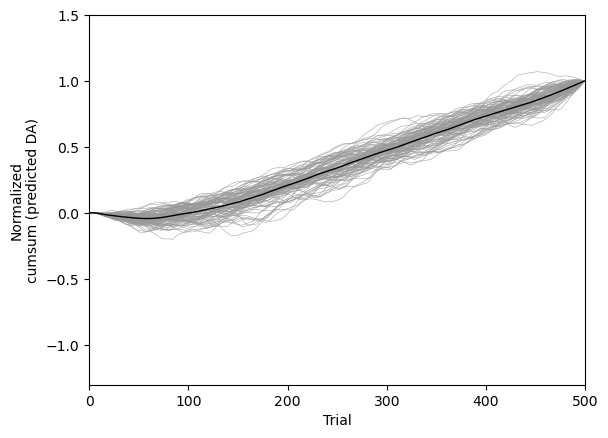

In [20]:
# FigS8J
import matplotlib.pyplot as plt

fHandle = plt.figure()

plt.plot(
    np.cumsum(rwrsp,axis=0) / np.tile(np.sum(rwrsp,axis=0), (numrewards,1)),
    color=[0.6,0.6,0.6],
    linewidth=0.35
)
plt.plot(np.mean(np.cumsum(rwrsp,axis=0)/np.tile(np.sum(rwrsp,axis=0),(numrewards,1)),axis=1),
         color='k',
         linewidth=1
)
plt.ylim([-1.3, 1.5])
plt.xlim([0, numrewards])
plt.xlabel('Trial')
plt.ylabel('Normalized\ncumsum (predicted DA)');
# plt.gca().set(xticklabels=[0,200,400],yticklabels=[-1,0,1])

In [17]:
DA,ANCCR,PRC,SRC,NC,Rs,Delta,Mij,Mi

(array([ 1.11405630e+00,  6.22368385e-01,  1.23332381e-01, -2.98202362e-01,
        -6.65068381e-01, -4.20466767e-01, -3.25460703e-01, -1.60773411e+00,
        -1.83158470e+00, -1.95236679e+00, -1.54360470e+00, -1.58331305e+00,
        -1.81248391e+00, -1.25016220e+00, -1.08217269e+00, -1.99853053e+00,
        -1.95325985e+00, -1.03178780e+00,  6.21638625e-01,  5.11957457e-01,
         9.08194536e-01,  9.29877423e-01,  6.59321967e-01,  4.17417836e-01,
        -1.80436543e-02, -2.13349339e-01, -6.63071684e-01, -1.69129824e+00,
        -2.50190914e+00, -2.62349091e+00, -2.84789921e+00, -3.07785594e+00,
        -3.37962690e+00, -4.27325373e+00, -4.26997865e+00, -4.24442705e+00,
        -4.41545923e+00, -4.15742061e+00, -3.98967215e+00, -3.91526347e+00,
        -2.64271636e+00, -2.47997795e+00, -2.47346868e+00, -2.81146951e+00,
        -3.11862573e+00, -3.26825299e+00, -3.42745416e+00, -3.88874956e+00,
        -3.81352596e+00, -3.52081026e+00, -2.54242950e+00, -1.67240182e+00,
        -1.5

In [25]:
DA.mean()

1.5790877271460633

In [28]:
DA.sum()

789.5438635730317

In [26]:
DA[:10]

array([ 1.1140563 ,  0.95337548,  0.30576715,  0.01540529, -0.37167622,
       -0.74617069,  0.51816826,  0.42927377, -0.1007545 ,  0.10995292])

In [27]:
np.cumsum(rwrsp,axis=0)

array([[  1.1140563 ,   1.1140563 ,   1.1140563 , ...,   1.1140563 ,
          1.1140563 ,   1.1140563 ],
       [  1.78414215,   1.77840697,   1.83427705, ...,   1.8170618 ,
          1.87141425,   2.06743179],
       [  2.05337878,   1.94683139,   2.12250017, ...,   2.74872357,
          2.11735663,   2.37319894],
       ...,
       [781.1068567 , 741.59169322, 653.04015858, ..., 757.699986  ,
        725.19937427, 781.15854983],
       [781.52898339, 745.91919868, 652.85644827, ..., 759.05698957,
        728.13510106, 785.31555021],
       [781.26325436, 750.43567513, 652.483886  , ..., 760.30022481,
        731.84477971, 789.54386357]])

In [ ]:
np.cumsum(rwrsp,axis=0) / np.tile(np.sum(rwrsp,axis=0), (numrewards,1))

In [29]:
(DA == ANCCR).all()

True

In [30]:
(NC == ANCCR).all()

True

In [46]:
(PRC[:, :, 1:100].round(4) == SRC[:, :, 1:100].round(4)).all()

True

In [17]:
np.tile(Mi[:, 1], (2, 1))

array([[0.78334708],
       [0.78334708]])

In [18]:
np.tile(Mi[:, 1], (2, 1)).T

array([[0.78334708, 0.78334708]])

In [19]:
np.tile(Mi[:, 1], (2, 1)) / np.tile(Mi[:, 1], (2, 1)).T

array([[1., 1.],
       [1., 1.]])

In [21]:
threshold

0.6

In [26]:
np.mean(NC[:, 0, max([0, 2 - 0]):2+1], axis=1) > threshold

array([False])

In [28]:
NC[:, 0, 2]

array([-0.64904152])

# Reward magnitude changes

In [38]:
# Task parameters
cuerewdelay = [1, 1, 1]
postrewdelay = [1, 1, 1]
numcue = [50, 900, 50]
rew_mags = [1, 5, 10]
rew_probs = [1, 1, 1]
meanITI = [30, 30, 30]
maxITI = [i * 3 for i in meanITI]
IRI = [x + y for x, y in zip(meanITI, cuerewdelay)]

# Model parameters
samplingperiod = 0.2
alpha = 0.02
alpha_r = alpha * 10
w = 0.5
k = 1
Tratio = 1.2
minimumrate = 10 ** (-3)
threshold = 0.6
maximumjitter = 0.1
beta = np.array([[0, 1]])
Rtrue = np.array([[0, 1]])
nIter = 20
da_means = [[float('nan') for _ in range(nIter)] for _ in range(3)]
da_stds = [[float('nan') for _ in range(nIter)] for _ in range(3)]

In [36]:
import numpy as np

def simulateEvents(n_cues, cue_label, reward_label,
                   reward_mag, omissionlabel, mean_ITI, max_ITI,
                   cue_rew_delay, rew_prob,
                   postrewdelay, bgdrw_label=None,
                   bgdrw_IRI=None, bgdrw_cue_delay=None,
                   bgdrw_mag=None):
    # SIMULATEEVENTS: Output an eventlog for the given cue reward parameters.

    # First check if one cue or multiple are being simulated (scalar vs. array)
    if len(mean_ITI) == 1:
        mean_ITI = [mean_ITI[0]] * len(cue_label)
    if len(max_ITI) == 1:
        max_ITI = [max_ITI[0]] * len(cue_label)
    if len(cue_rew_delay) == 1:
        cue_rew_delay = [cue_rew_delay[0]] * len(cue_label)
    if len(postrewdelay) == 1:
        postrewdelay = [postrewdelay[0]] * len(cue_label)
    if len(reward_mag) == 1:
        reward_mag = [reward_mag[0]] * len(cue_label)

    eventlog = np.empty((2 * sum(n_cues), 3))
    eventlog[:] = np.nan  # Initialize eventlog
    # For multiple unique cues, generate random sequence to present cues
    order_cue = np.concatenate([np.ones(x) * y for x, y in zip(n_cues, range(1, len(cue_label) + 1))])
    np.random.shuffle(order_cue)

    running_time = 0
    running_idx = 0
    
    for i in range(sum(n_cues)):
        running_idx += 1
        icue = int(order_cue[i])  # Index of unique cue being generated
        new_ts = np.random.exponential(mean_ITI[icue - 1])  # Exp. dist. timestamp for given cue
        if new_ts > max_ITI[icue - 1]:
            # If new ts exceeds max, set to max
            new_ts = max_ITI[icue - 1]
        # Update eventlog with cue label and new timestamp
        eventlog[running_idx - 1, 0] = cue_label[icue - 1]
        eventlog[running_idx - 1, 1] = new_ts + running_time
        eventlog[running_idx - 1, 2] = 0
        running_time += new_ts  # Update running time
        if rew_prob[icue - 1] > np.random.rand():  # Rng to determine if reward is delivered
            running_idx += 1
            eventlog[running_idx - 1, 0] = reward_label[icue - 1]
            eventlog[running_idx - 1, 1] = running_time + cue_rew_delay[icue - 1]
            eventlog[running_idx - 1, 2] = reward_mag[icue - 1]
            running_time += cue_rew_delay[icue - 1]
        else:
            # If no reward is delivered and omission is being tracked, save
            # omission instance in eventlog
            if not np.isnan(omissionlabel[icue - 1]):
                running_idx += 1
                eventlog[running_idx - 1, 0] = omissionlabel[icue - 1]
                eventlog[running_idx - 1, 1] = running_time + cue_rew_delay[icue - 1]
                eventlog[running_idx - 1, 2] = 0
                running_time += cue_rew_delay[icue - 1]
        running_time += postrewdelay[icue - 1]

    # Estimate number of rewards based on reward probability
    meanrewardnum = [float('nan')] * len(cue_label)
    for icue in range(len(cue_label)):
        meanrewardnum[icue] = rew_prob[icue]
        
    # If background rewards are also being simulated...
    if bgdrw_IRI is not None:
        # Generate sufficient backgoround rewards (based on running time)
        numbgdrw = int(round(running_time / bgdrw_IRI)) + 100
        eventlog_bgdrw = simulateBackgroundRewards(numbgdrw, bgdrw_IRI, bgdrw_label, bgdrw_mag, 0)
        eventlog_bgdrw = eventlog_bgdrw[eventlog_bgdrw[:, 1] <= running_time]
        for icue in range(len(cue_label)):
            cuetimes = eventlog[eventlog[:, 0] == cue_label[icue], 1]
            # Find instances where background rewards are too close to cues
            in_bgdrw_cue_delay = np.sum([[(x - y <= bgdrw_cue_delay) & (x - y >= 0) for y in eventlog_bgdrw[:, 1]] for x in cuetimes], axis=0) > 0
            # Find instances where background rewards are in cue/rew delay
            in_cue_rew_delay = np.sum([[(y - x <= cue_rew_delay[icue] + postrewdelay[icue]) & (y - x >= 0) for y in eventlog_bgdrw[:, 1]] for x in cuetimes], axis=0) > 0
            out = in_bgdrw_cue_delay | in_cue_rew_delay
            # Remove instances of background rewards that satisfy above
            eventlog_bgdrw = eventlog_bgdrw[~out]
            meanrewardnum[icue] += (mean_ITI[icue] - bgdrw_cue_delay) / bgdrw_IRI
        # Update eventlog with background rewards and sort by time
        eventlog = np.concatenate((eventlog, eventlog_bgdrw))
        eventlog = eventlog[eventlog[:, 1].argsort()]

    # Calculate the mean interreward interval
    IRI = sum([(x + y + z) * (a / n_cues[0]) for x, y, z, a in zip(cue_rew_delay, mean_ITI, postrewdelay, n_cues)]) / sum([x * (y / n_cues[0]) for x, y in zip(meanrewardnum, n_cues)])
    # Remove nans from final eventlog
    eventlog = eventlog[~np.isnan(eventlog).any(axis=1)]
    
    return eventlog, IRI

In [40]:
# Run simulation
# Simulate for cue reward pairs with three different magnitudes
for iIter in range(nIter):
    # Simulate cue and reward delivery
    eventlog, _ = simulateEvents(numcue, [1, 1, 1], [2, 2, 2], rew_mags, float('nan'),
                              meanITI, maxITI, cuerewdelay, rew_probs, postrewdelay)

    # Calculate model values
    DA, ANCCR, PRC, SRC, NC, Rs, Delta, Mij, Mi = calculate_anccr(eventlog, IRI[0] * Tratio,
                                                 alpha, k,
                                                 samplingperiod,
                                                 w,
                                                 threshold,
                                                 minimumrate,
                                                 beta,
                                                 alpha_r,
                                                 maximumjitter,
                                                 float('nan'),
                                                 float('nan'))

    # Find indices corresponding to each reward magnitude
    tens = [i for i in range(len(eventlog)) if eventlog[i][2] == 10]
    fives = [i for i in range(len(eventlog)) if eventlog[i][2] == 5]
    ones = [i for i in range(len(eventlog)) if eventlog[i][2] == 1]

    # Save separate DA responses for each reward magnitude
    da_10 = [DA[i] for i in tens]
    da_5 = [DA[i] for i in fives]
    da_1 = [DA[i] for i in ones]
    da_means[0][iIter] = sum(da_1) / len(da_1)
    da_means[1][iIter] = sum(da_5) / len(da_5)
    da_means[2][iIter] = sum(da_10) / len(da_10)

/tmp/ipykernel_25/1831270426.py:134: RuntimeWarning: invalid value encountered in true_divide
  SRC[:, :, jt] = PRC[:, :, jt] * np.tile(Mi[:, jt], (nstimuli, 1)) / np.tile(Mi[:, jt], (nstimuli, 1)).T


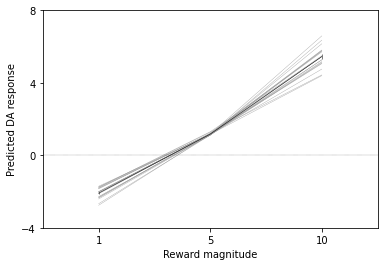

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Plot mean values
fig, ax = plt.subplots()
ax.plot(range(1, 4), da_means, color=[0.6, 0.6, 0.6], linewidth=0.35)
ax.errorbar(range(1, 4), np.mean(da_means, axis=1), np.std(da_means, axis=1) / np.sqrt(nIter), color='k', linewidth=0.5)
ax.plot([0, 4], [0, 0], linestyle=':', color='k', linewidth=0.35)
ax.set_xticks(range(1, 4))
ax.set_xticklabels(rew_mags)
ax.set_yticks(range(-4, 9, 4))
ax.set_ylim([-4, 8])
ax.set_xlim([0.5, 3.5])
ax.set_xlabel('Reward magnitude')
ax.set_ylabel('Predicted DA response')
plt.show()

In [48]:
eventlog[:10]

array([[ 1.        , 43.62440152,  0.        ],
       [ 2.        , 44.62440152,  5.        ],
       [ 1.        , 57.67675524,  0.        ],
       [ 2.        , 58.67675524,  5.        ],
       [ 1.        , 63.23928777,  0.        ],
       [ 2.        , 64.23928777,  5.        ],
       [ 1.        , 84.9371234 ,  0.        ],
       [ 2.        , 85.9371234 ,  5.        ],
       [ 1.        , 91.70593499,  0.        ],
       [ 2.        , 92.70593499,  5.        ]])

# Reward Probability

In [150]:
import numpy as np

# Task parameters
meanITI = np.array([100])
maxITI = [meanITI[0] * 3]
cuerewdelay = [0.5]
postrewdelay = [1]
numcue = [3000]

# Model parameters
samplingperiod = 0.2
alpha = 0.02
alpha_r = 0.2
w = 0.6
k = 0.01
Tratio = 1.2
minimumrate = 10 ** (-3)
threshold = 0.6
maximumjitter = 0.1
beta = np.array([[0, 1, 0]])

nIter = 3  # 20
rew_probs = np.array([[0.3, 0.6, 0.9]])
IRI = (meanITI + cuerewdelay) / rew_probs[0]

probability_results = np.empty((nIter, rew_probs.shape[1], beta.shape[1]))
probability_results[:] = np.nan

# Run simulation
# Simulate for cue reward pairs with three different reward probabilities
DA = []
for j in range(rew_probs.shape[1]):
    for iIter in range(nIter):
        print(iIter)
        # Simulate cue/reward delivery
        eventlog, _ = simulateEvents(numcue, [1], [2], [1], [3],
                                  meanITI, maxITI, cuerewdelay,
                                  rew_probs[:, j], postrewdelay)

        om_resp = np.zeros(sum(eventlog[:, 0] == 3))
        omidx = np.where(eventlog[:, 0] == 3)[0]
        # Recognition of omission state is dependent on the probability of reward
        # if the reward probability is 10%, you would expect omission state after cue only in a 10% probability
        outom = np.sort(np.random.choice(len(omidx), int(len(omidx) * (1 - rew_probs[:, j])), replace=False))
        # eventlog[omidx[outom]] = []
        eventlog = np.delete(eventlog, omidx[outom], axis=0)

        # Calculate model values
        DA, ANCCR, PRC, SRC, NC, Rs, Delta, Mij, Mi = calculate_anccr(eventlog,
                                                     IRI[1] * Tratio,
                                                     alpha,
                                                     k,
                                                     samplingperiod,
                                                     w,
                                                     threshold,
                                                     minimumrate,
                                                     beta,
                                                     alpha_r,
                                                     maximumjitter,
                                                     float('nan'),
                                                     np.array([[3], [2]]))

        # Save cue, reward, omission indices
        cue_resp = DA[eventlog[:, 0] == 1]
        rew_resp = DA[eventlog[:, 0] == 2]
        om_resp[~np.isin(range(len(omidx)), outom)] = DA[eventlog[:, 0] == 3]
        probability_results[iIter][j][0] = np.mean(cue_resp[-101:])
        probability_results[iIter][j][1] = np.mean(rew_resp[-101:])
        probability_results[iIter][j][2] = np.mean(om_resp[-101:])

0


/tmp/ipykernel_25/3095786554.py:134: RuntimeWarning: invalid value encountered in true_divide
  SRC[:, :, jt] = PRC[:, :, jt] * np.tile(Mi[:, jt], (nstimuli, 1)) / np.tile(Mi[:, jt], (nstimuli, 1)).T
/tmp/ipykernel_25/3095786554.py:134: RuntimeWarning: divide by zero encountered in true_divide
  SRC[:, :, jt] = PRC[:, :, jt] * np.tile(Mi[:, jt], (nstimuli, 1)) / np.tile(Mi[:, jt], (nstimuli, 1)).T


1
2
0
1
2
0
1
2


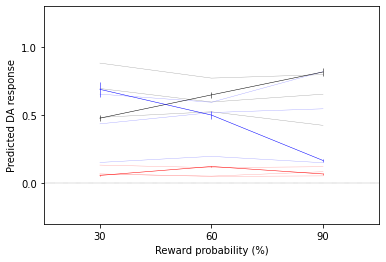

In [152]:
import matplotlib.pyplot as plt

# Plot reward probability results
clr_light = [[0.6, 0.6, 0.6], [0.6, 0.6, 1], [1, 0.6, 0.6]]
clr = [[0, 0, 0], [0, 0, 1], [1, 0, 0]]
fig, ax = plt.subplots()
for i in range(3):
    ax.plot(range(1, 4), np.squeeze(probability_results[:, :, i]), color=clr_light[i], linewidth=0.35)
    ax.errorbar(range(1, 4), np.mean(probability_results[:, :, i], axis=0),
                np.std(probability_results[:, :, i], axis=0) / np.sqrt(nIter),
                color=clr[i], linewidth=0.5)
ax.plot([0, 4], [0, 0], linestyle=':', color='k', linewidth=0.35)
ax.set_xticks(range(1, 4))
ax.set_xticklabels([int(x * 100) for x in rew_probs[0]])
ax.set_yticks(np.arange(-0.5, 1.5, 0.5))
ax.set_ylim([-0.3, 1.3])
ax.set_xlim([0.5, 3.5])
ax.set_xlabel('Reward probability (%)')
ax.set_ylabel('Predicted DA response')
plt.show()